- David Aarhus
- Monika Simikic
- Martin Zuber

# Data Import

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from google.colab import files
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar, ggtitle, theme, scale_x_continuous



stop_words = set(stopwords.words('english'))

uploaded = files.upload()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saving 2011_nfl_pbp_data.csv to 2011_nfl_pbp_data.csv
Saving 2009_nfl_pbp_data.csv to 2009_nfl_pbp_data.csv
Saving 2010_nfl_pbp_data.csv to 2010_nfl_pbp_data.csv
Saving 2008_nfl_pbp_data.csv to 2008_nfl_pbp_data.csv
Saving 2007_nfl_pbp_data.csv to 2007_nfl_pbp_data.csv
Saving 2006_nfl_pbp_data.csv to 2006_nfl_pbp_data.csv
Saving 2005_nfl_pbp_data.csv to 2005_nfl_pbp_data.csv
Saving 2004_nfl_pbp_data.csv to 2004_nfl_pbp_data.csv
Saving 2003_nfl_pbp_data.csv to 2003_nfl_pbp_data.csv
Saving 2002_nfl_pbp_data.csv to 2002_nfl_pbp_data.csv


#Data Preprocessing and Exploration

In [ ]:

# List to hold all DataFrames
all_dfs = []

for year in range(2002, 2012):  # for years 2002 to 2011
    file_name = '/content/{}_nfl_pbp_data.csv'.format(year)
    df = pd.read_csv(file_name)

    # Adding 'year' column to keep track of data origin

    all_dfs.append(df)

# concatenating all dataframes
df = pd.concat(all_dfs, ignore_index=True)

# remove rows with NaN values
df = df.dropna()

# remove rows that have a qtr value of 5 (does not exist in football)
df = df[df['qtr'] != 5]

# seperates play part of the description, from the penalty part of the description
df[['play', 'penalty']] = df['description'].str.lower().str.split('penalty', n=1, expand=True)

# Replace 'penalty' values to None when 'penalty' is not present in 'description'
df['penalty'] = df.apply(lambda row: None if row['penalty'] is None or 'on' not in row['penalty'] else row['penalty'], axis=1)

# tells us if offensive team is in the shotgun formation pre-snap
df['is_shotgun'] = df['play'].apply(lambda x: 1 if 'shotgun' in x else 0)

# creates new column 'togo_class, puts yards to go into three categorical variables.
df['togo_class'] = df['togo'].apply(lambda x: 'short' if x <= 3 else ('medium' if 3 < x <= 8 else 'long'))

# creates new column 'redzone, labels whether the play is within the redzone or not.
df['redzone'] = df['ydline'].apply(lambda x: 1 if (0 < x <=20) else 0)

# extract net yards on play
def extract_yards(text):
    match = re.search('for (-?\d+) yard(s)?', text)
    return match.group(1) if match else None
df['yards(+/-)'] = df['play'].apply(extract_yards)

print("Total Plays: {}".format(len(df)))


Total Plays: 387460


### PassPlay Labeling (0 or 1)

- We had to conduct a word count and a tri-gram count on the 'play' column to help identify which plays were a pass play or not. This helped because we were able to sort each list (word count and tri-gram count) by most occurences to see which words would being used the most. This allowed up to identify the most commonly used terminology for identifying the play.
  - For example, plays accompanied with the word 'pass','incomplete','sacked','scrambles','caught', and 'catch' most of the time indicated the play was a pass play.
  - Also using Tri-grams, we help identify plays that were not pass plays (i.e. rushing plays). For example, anything with 'up the middle' usually indicated rushing plays
- We then looked through the top 300-500 words/trig-rams and hand picked the terms we felt correctly identified the play.
- We did not have to go through all the terms because as you went through the list the terms then became names, teams, etc which did not assist in identifying what kind of play it was for this project.



In [ ]:
# returns word count for given string.
def play_processing_count(play):
    if isinstance(play, str):
        word_tokens = word_tokenize(play.lower())
        word_count = {}
        for word in word_tokens:
            if word not in stop_words and word.isalpha(): #not a stop word and is a string/ true comment
                if word in word_count:
                  word_count[word] += 1
                else:
                  word_count[word] = 1
        return word_count
    else:
        return {}

#returns dictionary for each play
def trigram_processing_count(play):
    if isinstance(play, str):
        play = re.sub(r'\(.*?\)', '', play)  # remove text within parentheses
        play = re.sub(r'\b\w*\.\w*\b', '', play)  # remove words with a .
        word_tokens = word_tokenize(play.lower())
        trigrams = list(ngrams(word_tokens, 3)) #create trigrams
        trigram_count = {}
        for trigram in trigrams:
            joined_trigram = ' '.join(trigram) # join the words in each trigram
            if joined_trigram in trigram_count:
                trigram_count[joined_trigram] += 1
            else:
                trigram_count[joined_trigram] = 1
        return trigram_count
    else:
        return {}

processed_play_count = df['play'].apply(play_processing_count)
processed_trigram_count = df['play'].apply(trigram_processing_count)

total_word_count = defaultdict(int)
tri_gram_total_word_count = defaultdict(int)

#aggregate across entire dataset
for word_count_dict in processed_play_count:
  for word, count in word_count_dict.items():
    total_word_count[word] += count

#aggregate across entire dataset
for tri_gram_word_count_dict in processed_trigram_count:
  for word, count in tri_gram_word_count_dict.items():
    tri_gram_total_word_count[word] += count


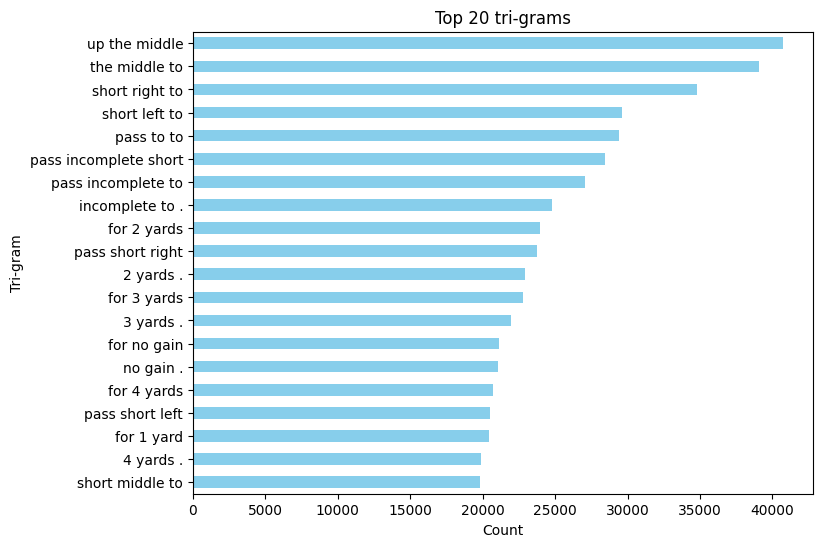

In [ ]:
tri_gram_word_count_df = pd.DataFrame(list(tri_gram_total_word_count.items()), columns=["Tri-gram" , "Count"])
tri_gram_word_count_df = tri_gram_word_count_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

tri_gram_word_count_df.set_index('Tri-gram', inplace=True) # Set 'Tri-gram' as the index
tri_gram_word_count_df[:20].plot(kind='barh', figsize=(8, 6), color ='skyblue', legend = False) # plot
plt.gca().invert_yaxis() # invert the order of the y-axis
plt.xlabel('Count') # gives the x-label
plt.ylabel('Tri-gram') # gives the y-label
plt.title('Top 20 tri-grams') # gives the title
plt.show() # Show the plot

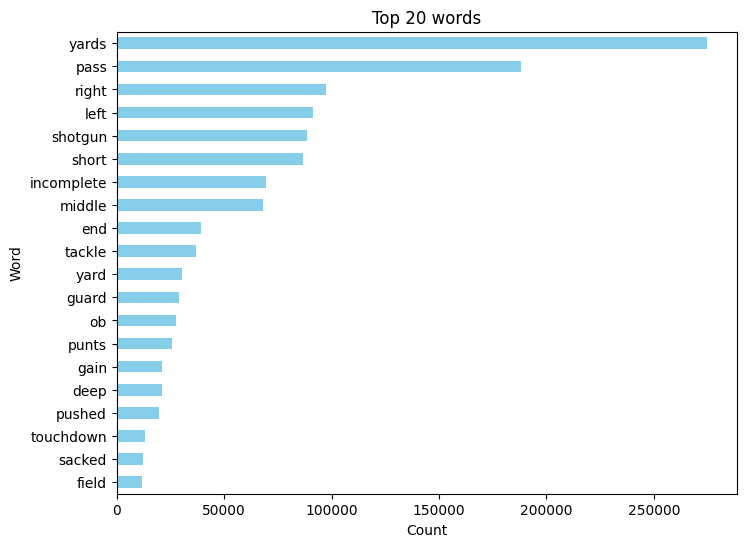

In [ ]:
word_count_df = pd.DataFrame(list(total_word_count.items()), columns=["Word" , "Count"])
word_count_df = word_count_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

word_count_df.set_index('Word', inplace=True) # Set 'Word' as the index
word_count_df[:20].plot(kind='barh', figsize=(8, 6), color ='skyblue', legend = False)
plt.gca().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 20 words')
plt.show()

In [ ]:
# hand picked these words because they usually indicate a pass play in the game of football
pass_words =['pass','incomplete','sacked','scrambles',
        'caught','catch','intercepted',
        'intended','coverage','sack','screen','thrown',
        'completion','passed','pressure','overthrown','tipped',
        'underthrown','breakup','dropped','passing',
        'interception','bootleg','catches', 'back to pass rushes']


# hand picked these phrases because they usually indicated a run play
rush_words =['up the middle','left end to','right tackle to','right end to',
        'right guard to','left tackle to','left guard to',
        'left end pushed','right end pushed']

In [ ]:
# identify PassPlays
df['PassPlay'] = df['description'].apply(lambda x: 1 if any(word in x for word in pass_words) else 0)

# identify Non-PassPlays
df['PassPlay'] = df['PassPlay'].where(~df['description'].apply(lambda x: any(word in x for word in rush_words)), 0)




#Data Exploration

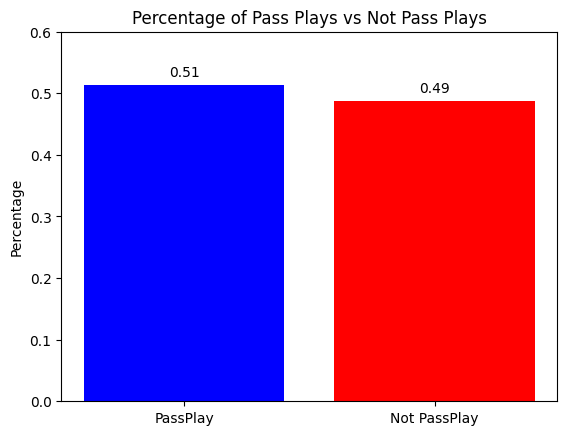

In [ ]:
# Values:
pass_play_pct = df['PassPlay'].mean()
not_pass_play_pct = 1 - pass_play_pct
categories = ['PassPlay', 'Not PassPlay']
values = [pass_play_pct, not_pass_play_pct]

# Plot:
bars = plt.bar(categories, values, color=['blue', 'red'])
plt.ylabel('Percentage')
plt.title('Percentage of Pass Plays vs Not Pass Plays')

# Adjust y limits:
plt.ylim(0, 0.6)

# Adding percentage values on bars:
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval,2), ha='center', va='bottom')

plt.show()

- Overall, PassPlays vs Non-Pass Plays was pretty split. 52% of the plays being a pass play and 48% being labeled as a non-passplay

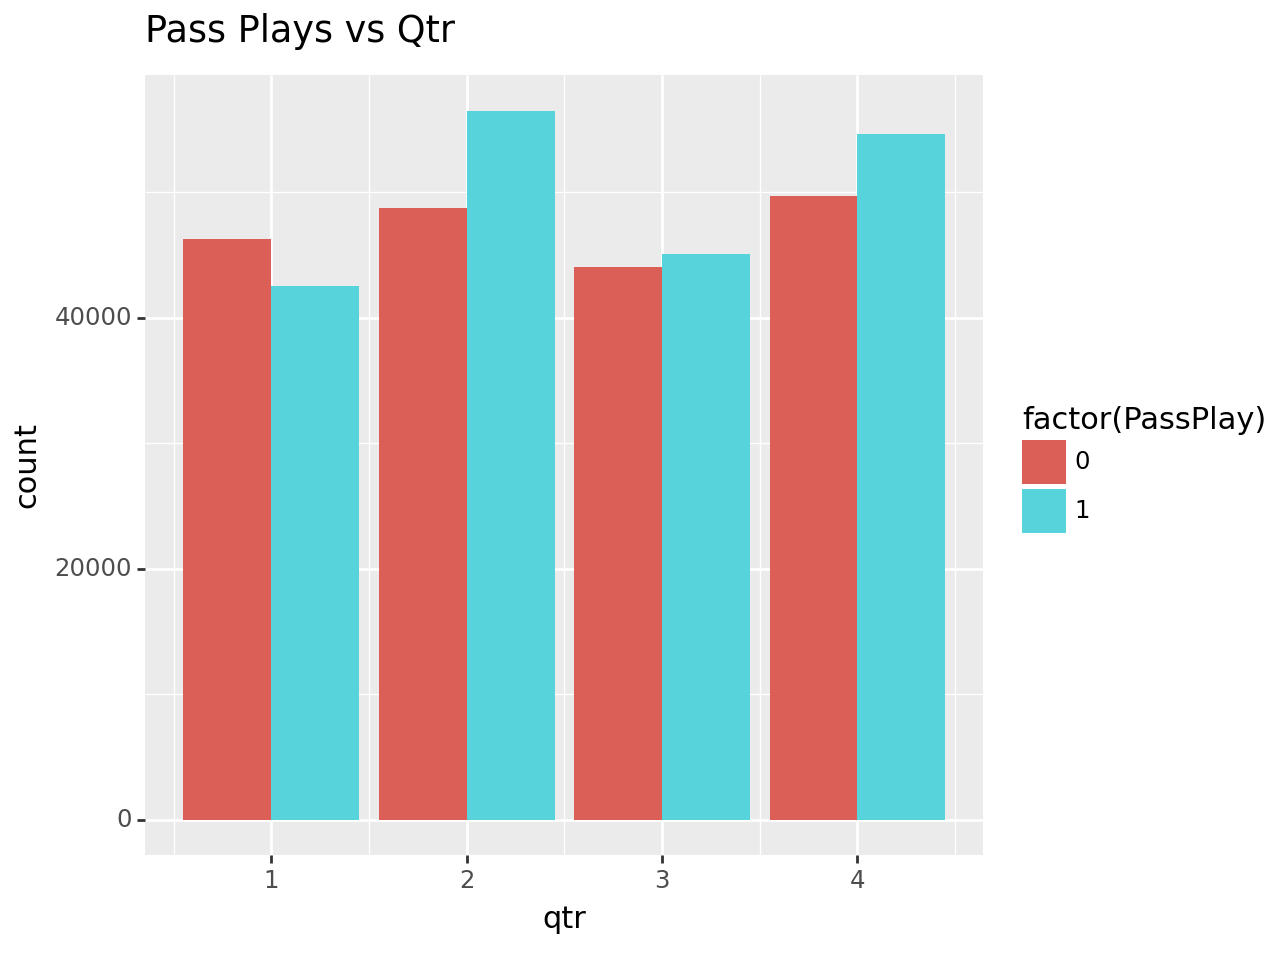

'\n    Hypothesis, teams tend to\n    throw the ball more towards end of\n    half/game so they can control the\n    clock more, or gain larger chunks of yards.\n\n    Also, some teams tend to have scripted plays the beginning of the 1st and 2nd halves.\n\n    # https://www.forbes.com/sites/jefffedotin/2023/08/15/why-nfl-teams-still-script-their-first-15-plays/?sh=577bfa8a581d\n'

In [ ]:
print(ggplot(df, aes('qtr', fill='factor(PassPlay)')) + geom_bar(position='dodge')+ ggtitle('Pass Plays vs Qtr'))

'''
    Hypothesis, teams tend to
    throw the ball more towards end of
    half/game so they can control the
    clock more, or gain larger chunks of yards.

    Also, some teams tend to have scripted plays the beginning of the 1st and 2nd halves.

    # https://www.forbes.com/sites/jefffedotin/2023/08/15/why-nfl-teams-still-script-their-first-15-plays/?sh=577bfa8a581d
'''


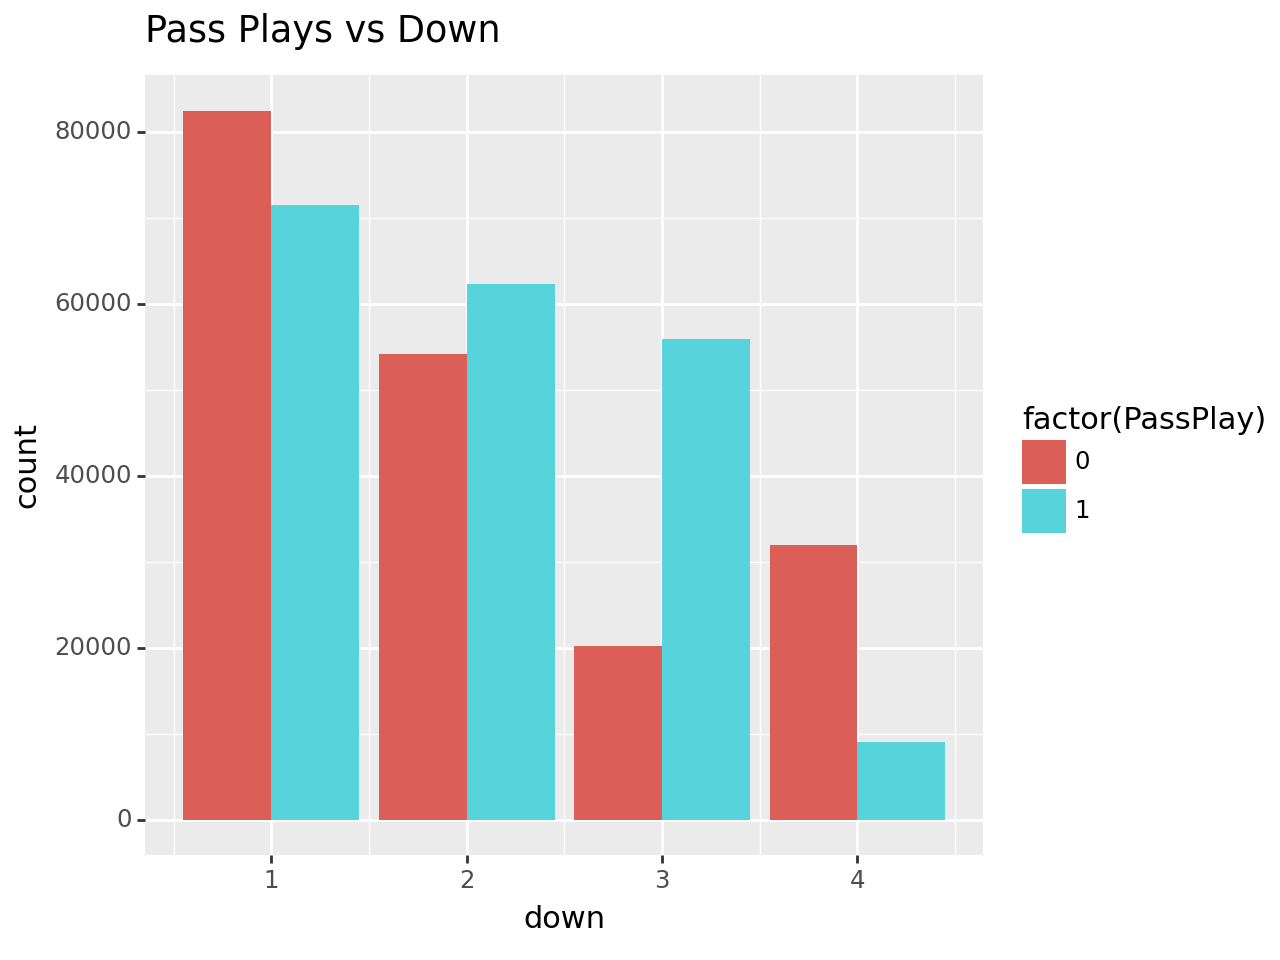

'\n    Hypothesis, teams tend to run\n    more on 1st down, compared to 2nd\n    and 3rd down.\n\n    https://www.bruinsportsanalytics.com/post/first-down-play-calling#:~:text=For%20teams%20that%20have%20a%20poor%20running%20and%20passing%20game,first%20down%20found%20more%20success.\n\n'

In [ ]:
print(ggplot(df, aes('down', fill='factor(PassPlay)')) + geom_bar(position='dodge') + ggtitle('Pass Plays vs Down'))

'''
    Hypothesis, teams tend to run
    more on 1st down, compared to 2nd
    and 3rd down.

    https://www.bruinsportsanalytics.com/post/first-down-play-calling#:~:text=For%20teams%20that%20have%20a%20poor%20running%20and%20passing%20game,first%20down%20found%20more%20success.

'''

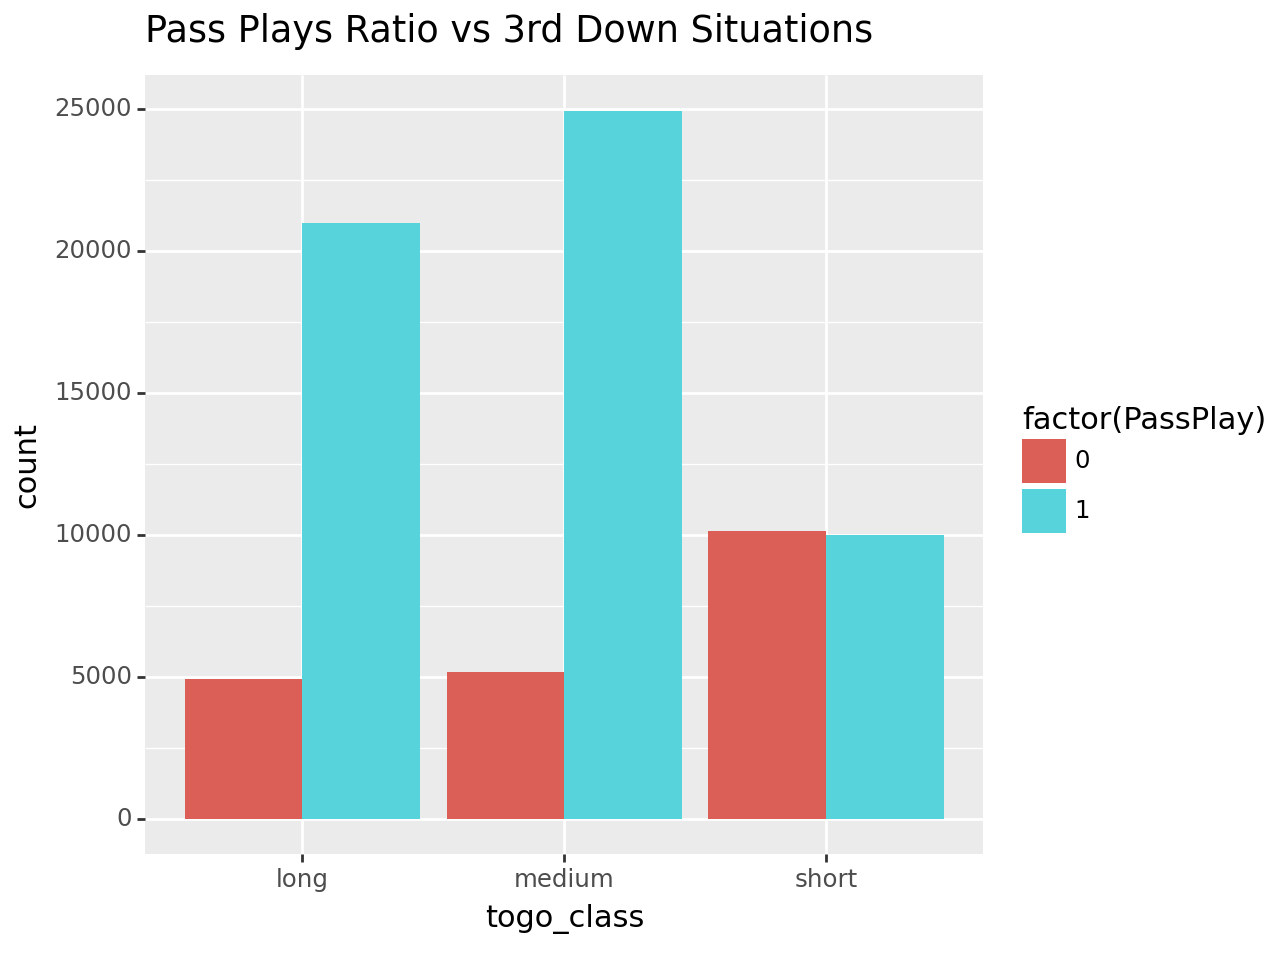

'\n    Hypothesis, when yards to go exceeds 8 or more\n    teams tend to rely on a pass play to gain enough\n    yards for a first down\n\n    https://www.thespax.com/nfl/analyzing-nfl-third-down-play-calling/\n'

In [ ]:

df_downs = df[df['down'] == 3.0]
print(ggplot(df_downs, aes('togo_class', fill='factor(PassPlay)')) + geom_bar(position='dodge')+ ggtitle('Pass Plays Ratio vs 3rd Down Situations'))
'''
    Hypothesis, when yards to go exceeds 8 or more
    teams tend to rely on a pass play to gain enough
    yards for a first down

    https://www.thespax.com/nfl/analyzing-nfl-third-down-play-calling/
'''



### Plass Play Distribution by Down

PassPlay         0         1
down                        
1.0       0.535659  0.464341
2.0       0.465035  0.534965
3.0       0.265991  0.734009
4.0       0.779704  0.220296
None


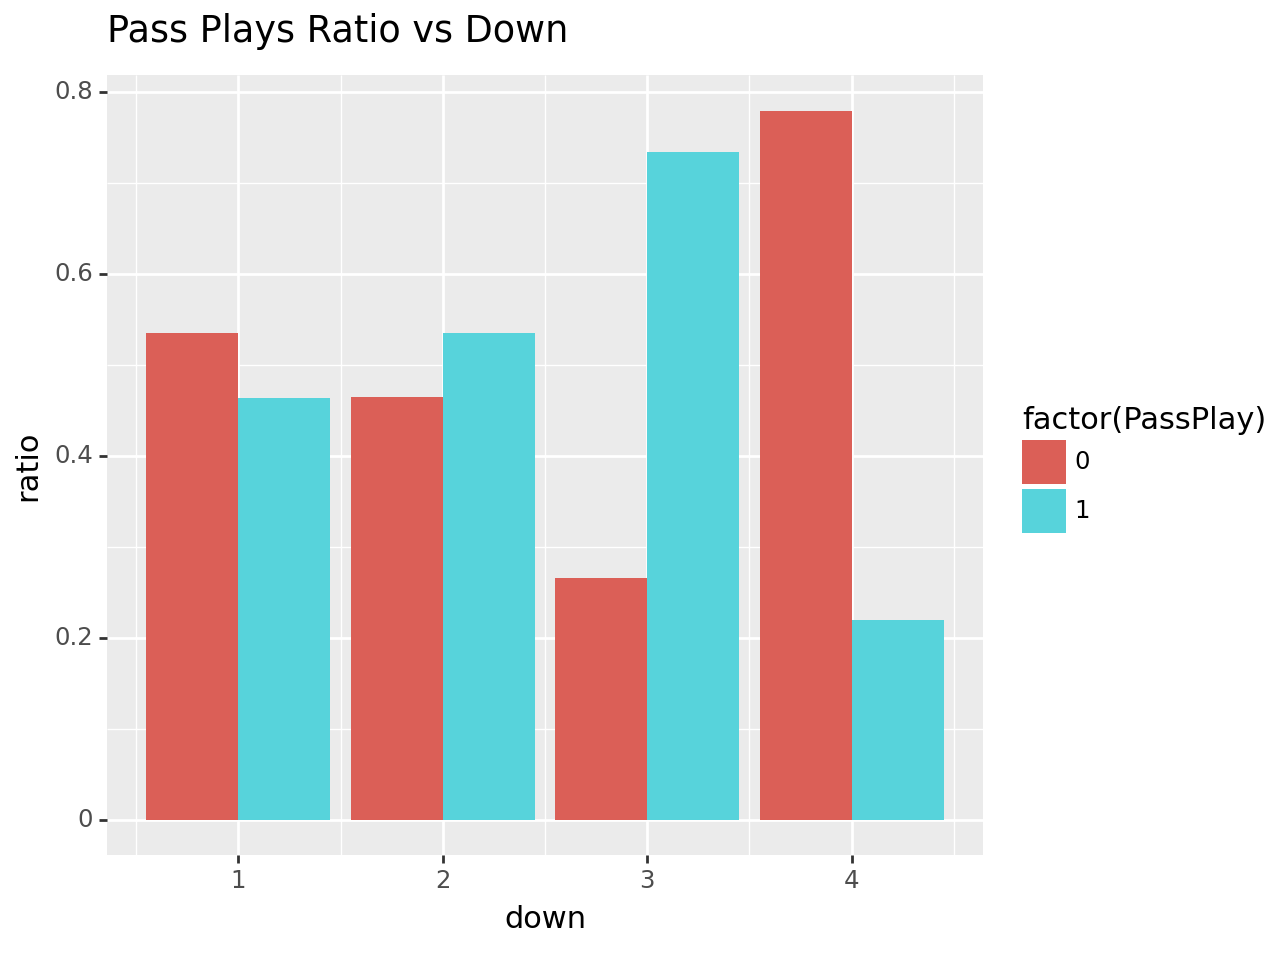

In [ ]:
ratio_df = df.groupby('down')['PassPlay'].value_counts(normalize=True).unstack() # Calculate the ratio
print(ratio_df)
print(ratio_df.reset_index(inplace=True)) # Reset the index
long_ratio_df = pd.melt(ratio_df, id_vars='down', var_name='PassPlay', value_name='ratio') # Melt the DataFrame to a long format
print(ggplot(long_ratio_df, aes('down', 'ratio', fill='factor(PassPlay)')) + geom_bar(stat='identity', position='dodge') + ggtitle('Pass Plays Ratio vs Down')) # Mak and print the graph


### Theories before modeling

- For 3rd down plays, togo_class variable will be valuable in predicting pass/non pass but will be difficult to get high accuracy since baseline is so high (>70%)
- qtr will have an impact on pass/non pass since teams tend to throw the ball more towards the end of halfs.
- predicting pass on 1st down will be most valuable, most room for increase from baseline (~46%).


#### additional engineered variables below

- home_team_boolean ( perhaps having home field advantage affects playcalling? )
- previous_play_penalty ( whether there was a penalty on the previous play )
- previous_play_type ( if the previous play was a pass play or not )
- previous_play_yard ( how many yards were gained or lost on the previous play )
- in_game_pass_ratio ( what ratio of plays were pass plays for the off team )



In [ ]:
test_df = df

test_df['home_team'] = test_df['gameid'].apply(lambda x: x.split("@")[1])
test_df['home_team_boolean'] = np.where(test_df['home_team'] == test_df['off'], 1, 0)


# convert to string if 'off' and 'def' columns are not already a string type
test_df['off'] = test_df['off'].astype(str)
test_df['def'] = test_df['def'].astype(str)

# Create columns for previous off and def values
test_df['previous_def'] = test_df['def'].shift(1)
test_df['previous_off'] = test_df['off'].shift(1)

# Create an indicator for possession shifts
test_df['possession_shift'] = np.where((test_df['off'] == test_df['previous_def']) & (test_df['def'] == test_df['previous_off']), True, False)


test_df['previous_play_penalty'] = test_df['penalty'].shift(1)
test_df['previous_play_yard'] = test_df['yards(+/-)'].shift(1)
test_df['previous_play_type'] = test_df['PassPlay'].shift(1)



# # convert NaN values to null in boolean column
test_df['previous_play_penalty'] = test_df['penalty'].shift(1).notnull().astype(int)

# # convert NaN or negative yard values to None in yards column
test_df['previous_play_yard'] = test_df['previous_play_yard'].where(test_df['previous_play_yard'].notnull() & test_df['previous_play_yard']>=0, other=None)


In [ ]:

def calculate_per_play_pass_ratio(df):
    # Sort dataframe
    df = df.sort_values(by=['gameid', 'off'])

    # Calculate cumulative number of pass plays and total plays for each game/off team
    df['cumulative_pass_plays'] = df.groupby(['gameid', 'off']).PassPlay.cumsum()
    df['cumulative_total_plays'] = df.groupby(['gameid', 'off']).cumcount() + 1

    # Calculate pass ratio per play
    df['in_game_pass_ratio'] = df['cumulative_pass_plays'] / df['cumulative_total_plays']

    # Shift the pass ratio to get the ratio up to the previous play
    df['in_game_pass_ratio'] = df.groupby(['gameid', 'off'])['in_game_pass_ratio'].shift(1)

    # Filling NaN values after shifting with 0
    df['in_game_pass_ratio'].fillna(0, inplace=True)

    # Remove temporary columns
    df.drop(['cumulative_pass_plays', 'cumulative_total_plays'], axis=1, inplace=True)

    return df

test_df = calculate_per_play_pass_ratio(test_df)

#Learning / Modeling

##### Quick Data Cleaning and One-hot Encoding

In [ ]:
test_df['sec'] = pd.to_numeric(test_df['sec'], errors='coerce') # converting non numeric seconds row values to NaN
test_df = test_df.dropna(subset=['sec']) # Drop rows with NaN in 'column_name'
test_df = test_df.reset_index(drop=True) # If you want to reset the index
test_df = pd.get_dummies(test_df, columns=['togo_class']) #One-hot Encoding

# Logistic Regression


In [ ]:
# Libraries again
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create working df
working_df = test_df.sample(20000)

# Split data into features (X) and target variable (y)
X = working_df[[ 'qtr', 'min', 'sec', 'ydline',
        'offscore', 'defscore', 'is_shotgun', 'redzone',
        'togo_class_long', 'togo_class_medium',
        'togo_class_short', 'home_team_boolean',
        'previous_play_penalty','previous_play_yard',
        'previous_play_type', 'in_game_pass_ratio']]
X = X.fillna(0)
sc = StandardScaler()
X = sc.fit_transform(X)
y = working_df["PassPlay"]  #this line is making PassPlay our target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LogisticRegression()
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Baseline: 0.51")
print("Accuracy:", accuracy)
# get features (variables)
variables = [ 'qtr', 'min', 'sec', 'ydline',
        'offscore', 'defscore', 'is_shotgun', 'redzone',
        'togo_class_long', 'togo_class_medium',
        'togo_class_short', 'home_team_boolean',
        'previous_play_penalty','previous_play_yard',
        'previous_play_type', 'in_game_pass_ratio']

# get coefficients
coefficients = model.coef_[0]

# create a dataframe of variables and their corresponding coefficients
coef_df = pd.DataFrame({'Variable':variables, 'Coefficient':coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print(coef_df)

# Additional evaluation metrics
print("****** RESULTS WHEN TESTING ACROSS ALL VARS ******")
print(classification_report(y_test, y_pred))

Baseline: 0.51
Accuracy: 0.6593517239598797
                 Variable  Coefficient
6              is_shotgun     0.786172
5                defscore     0.285973
9       togo_class_medium     0.083502
15     in_game_pass_ratio     0.059024
8         togo_class_long     0.045047
11      home_team_boolean     0.024794
2                     sec     0.006328
1                     min     0.002326
12  previous_play_penalty     0.001369
0                     qtr    -0.026476
3                  ydline    -0.063325
13     previous_play_yard    -0.067218
7                 redzone    -0.123285
14     previous_play_type    -0.150885
10       togo_class_short    -0.170419
4                offscore    -0.249200
****** RESULTS WHEN TESTING ACROSS ALL VARS ******
              precision    recall  f1-score   support

           0       0.61      0.80      0.70     37573
           1       0.74      0.52      0.61     39894

    accuracy                           0.66     77467
   macro avg       0.68 

# Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# from sklearn import svm
working_df = test_df.sample(20000)

# Split data into features (X) and target variable (y)
X = working_df[[ 'qtr', 'min', 'sec', 'ydline',
        'offscore', 'defscore', 'is_shotgun', 'redzone',
        'togo_class_long', 'togo_class_medium',
        'togo_class_short', 'home_team_boolean',
        'previous_play_penalty','previous_play_yard',
        'previous_play_type', 'in_game_pass_ratio']]
X = X.fillna(0)
y = working_df["PassPlay"]  #this line is making PassPlay our target variable

X_columns = X.columns

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Function to evaluate feature importances
def evaluate_feature_importance(model, X_train, feature_names):
    model.fit(X_train, y_train)
    X_train = pd.DataFrame(X_train, columns = X.columns)
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1]
    for f, idx in enumerate(sorted_idx):
        print("%d. %s (%f)" % (f + 1, feature_names[idx], importances[idx]))

# Train a random forest model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print("Random Forest Feature Importance (averaged across 100 trees):")
evaluate_feature_importance(rf, X_train, X.columns)

# Make predictions on testing set
y_pred_rf = rf.predict(X_test)

# Calculate accuracy of random forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


Random Forest Feature Importance (averaged across 100 trees):
1. ydline (0.137093)
2. in_game_pass_ratio (0.134802)
3. sec (0.129925)
4. min (0.118456)
5. is_shotgun (0.106364)
6. previous_play_yard (0.091668)
7. defscore (0.085195)
8. offscore (0.083698)
9. qtr (0.024102)
10. home_team_boolean (0.022520)
11. previous_play_type (0.018615)
12. previous_play_penalty (0.011731)
13. togo_class_short (0.009747)
14. togo_class_long (0.009723)
15. togo_class_medium (0.008890)
16. redzone (0.007472)
Random Forest Accuracy: 0.662


# K-Nearest Neighbors

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from collections import defaultdict


working_df = test_df.sample(20000)

X = working_df[[ 'qtr', 'min', 'sec', 'ydline',
        'offscore', 'defscore', 'is_shotgun', 'redzone',
        'togo_class_long', 'togo_class_medium',
        'togo_class_short', 'home_team_boolean',
        'previous_play_penalty','previous_play_yard',
        'previous_play_type', 'in_game_pass_ratio']]

X = X.fillna(0)
X_columns = X.columns
y = working_df[['PassPlay']]

sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initializing the values.
accuracies = []
max_accuracy = -1
best_k = -1

# range of 'k' can be 1 to sq.root(N). But for simplicity check from 1 to 20
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.values.ravel())
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_k = k

# Fit the model with best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train.values.ravel())

# Perform permutation importance
results = permutation_importance(knn, X_test, y_test.values.ravel(), scoring='accuracy')

print("Accuracy: ", max_accuracy)
print("Best K: ", best_k)

results = permutation_importance(knn, X_test, y_test.values.ravel(), scoring='accuracy')

importance = results.importances_mean
sorted_idx = np.argsort(importance)[::-1]
important_cols = [X_columns[idx] for idx in sorted_idx]
important_cols

Accuracy:  0.6572
Best K:  19


['is_shotgun',
 'previous_play_type',
 'offscore',
 'defscore',
 'min',
 'togo_class_short',
 'qtr',
 'ydline',
 'in_game_pass_ratio',
 'sec',
 'previous_play_yard',
 'home_team_boolean',
 'previous_play_penalty',
 'togo_class_long',
 'redzone',
 'togo_class_medium']

In [ ]:
from collections import defaultdict

working_df = test_df.copy()

# Dictionary to store the best models and their details
best_models = defaultdict()

# Loop over years and downs
for year in range(2002, 2012):
    for down in [1.0, 2.0, 3.0]:
        test_dfdf = working_df[(working_df['season'] == year) & (working_df['down'] == down)]
        if test_dfdf.empty:
            continue  # Skip if no records found for given year and down

        X = test_dfdf[[ 'qtr', 'min', 'sec', 'ydline',
        'offscore', 'defscore', 'is_shotgun', 'redzone',
        'togo_class_long', 'togo_class_medium',
        'togo_class_short', 'home_team_boolean',
        'previous_play_penalty','previous_play_yard',
        'previous_play_type', 'in_game_pass_ratio']]

        X = X.fillna(0)
        X_columns = X.columns
        y = test_dfdf[['PassPlay']]

        sc = StandardScaler()
        X = sc.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        # Function to evaluate feature importances
        def evaluate_feature_importance(model, X_train, y_train, feature_names):
          model.fit(X_train, y_train)
          importances = model.feature_importances_
          sorted_idx = importances.argsort()[::-1]
          feature_importance_dict = {}
          for f, idx in enumerate(sorted_idx):
              feature_importance_dict[feature_names[idx]] = importances[idx]
          return feature_importance_dict

        # Train a random forest model
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X_train, y_train)
        feature_importance_dict = evaluate_feature_importance(rf, X_train, y_train, X_columns)

        # Make predictions on testing set
        y_pred_rf = rf.predict(X_test)

        # Calculate accuracy of random forest
        accuracy_rf = accuracy_score(y_test, y_pred_rf)

        #Store the best model, its accuracy, and important features
        best_models[(year, down)] = {'Accuracy': accuracy_rf,
                                    'Important Features': feature_importance_dict}




<ipython-input-75-53f9d96b1165>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<ipython-input-75-53f9d96b1165>:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<ipython-input-75-53f9d96b1165>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<ipython-input-75-53f9d96b1165>:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<ipython-input-75-53f9d96b1165>:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
<ipython-input-75-53f9d96b1165>:32: DataConve

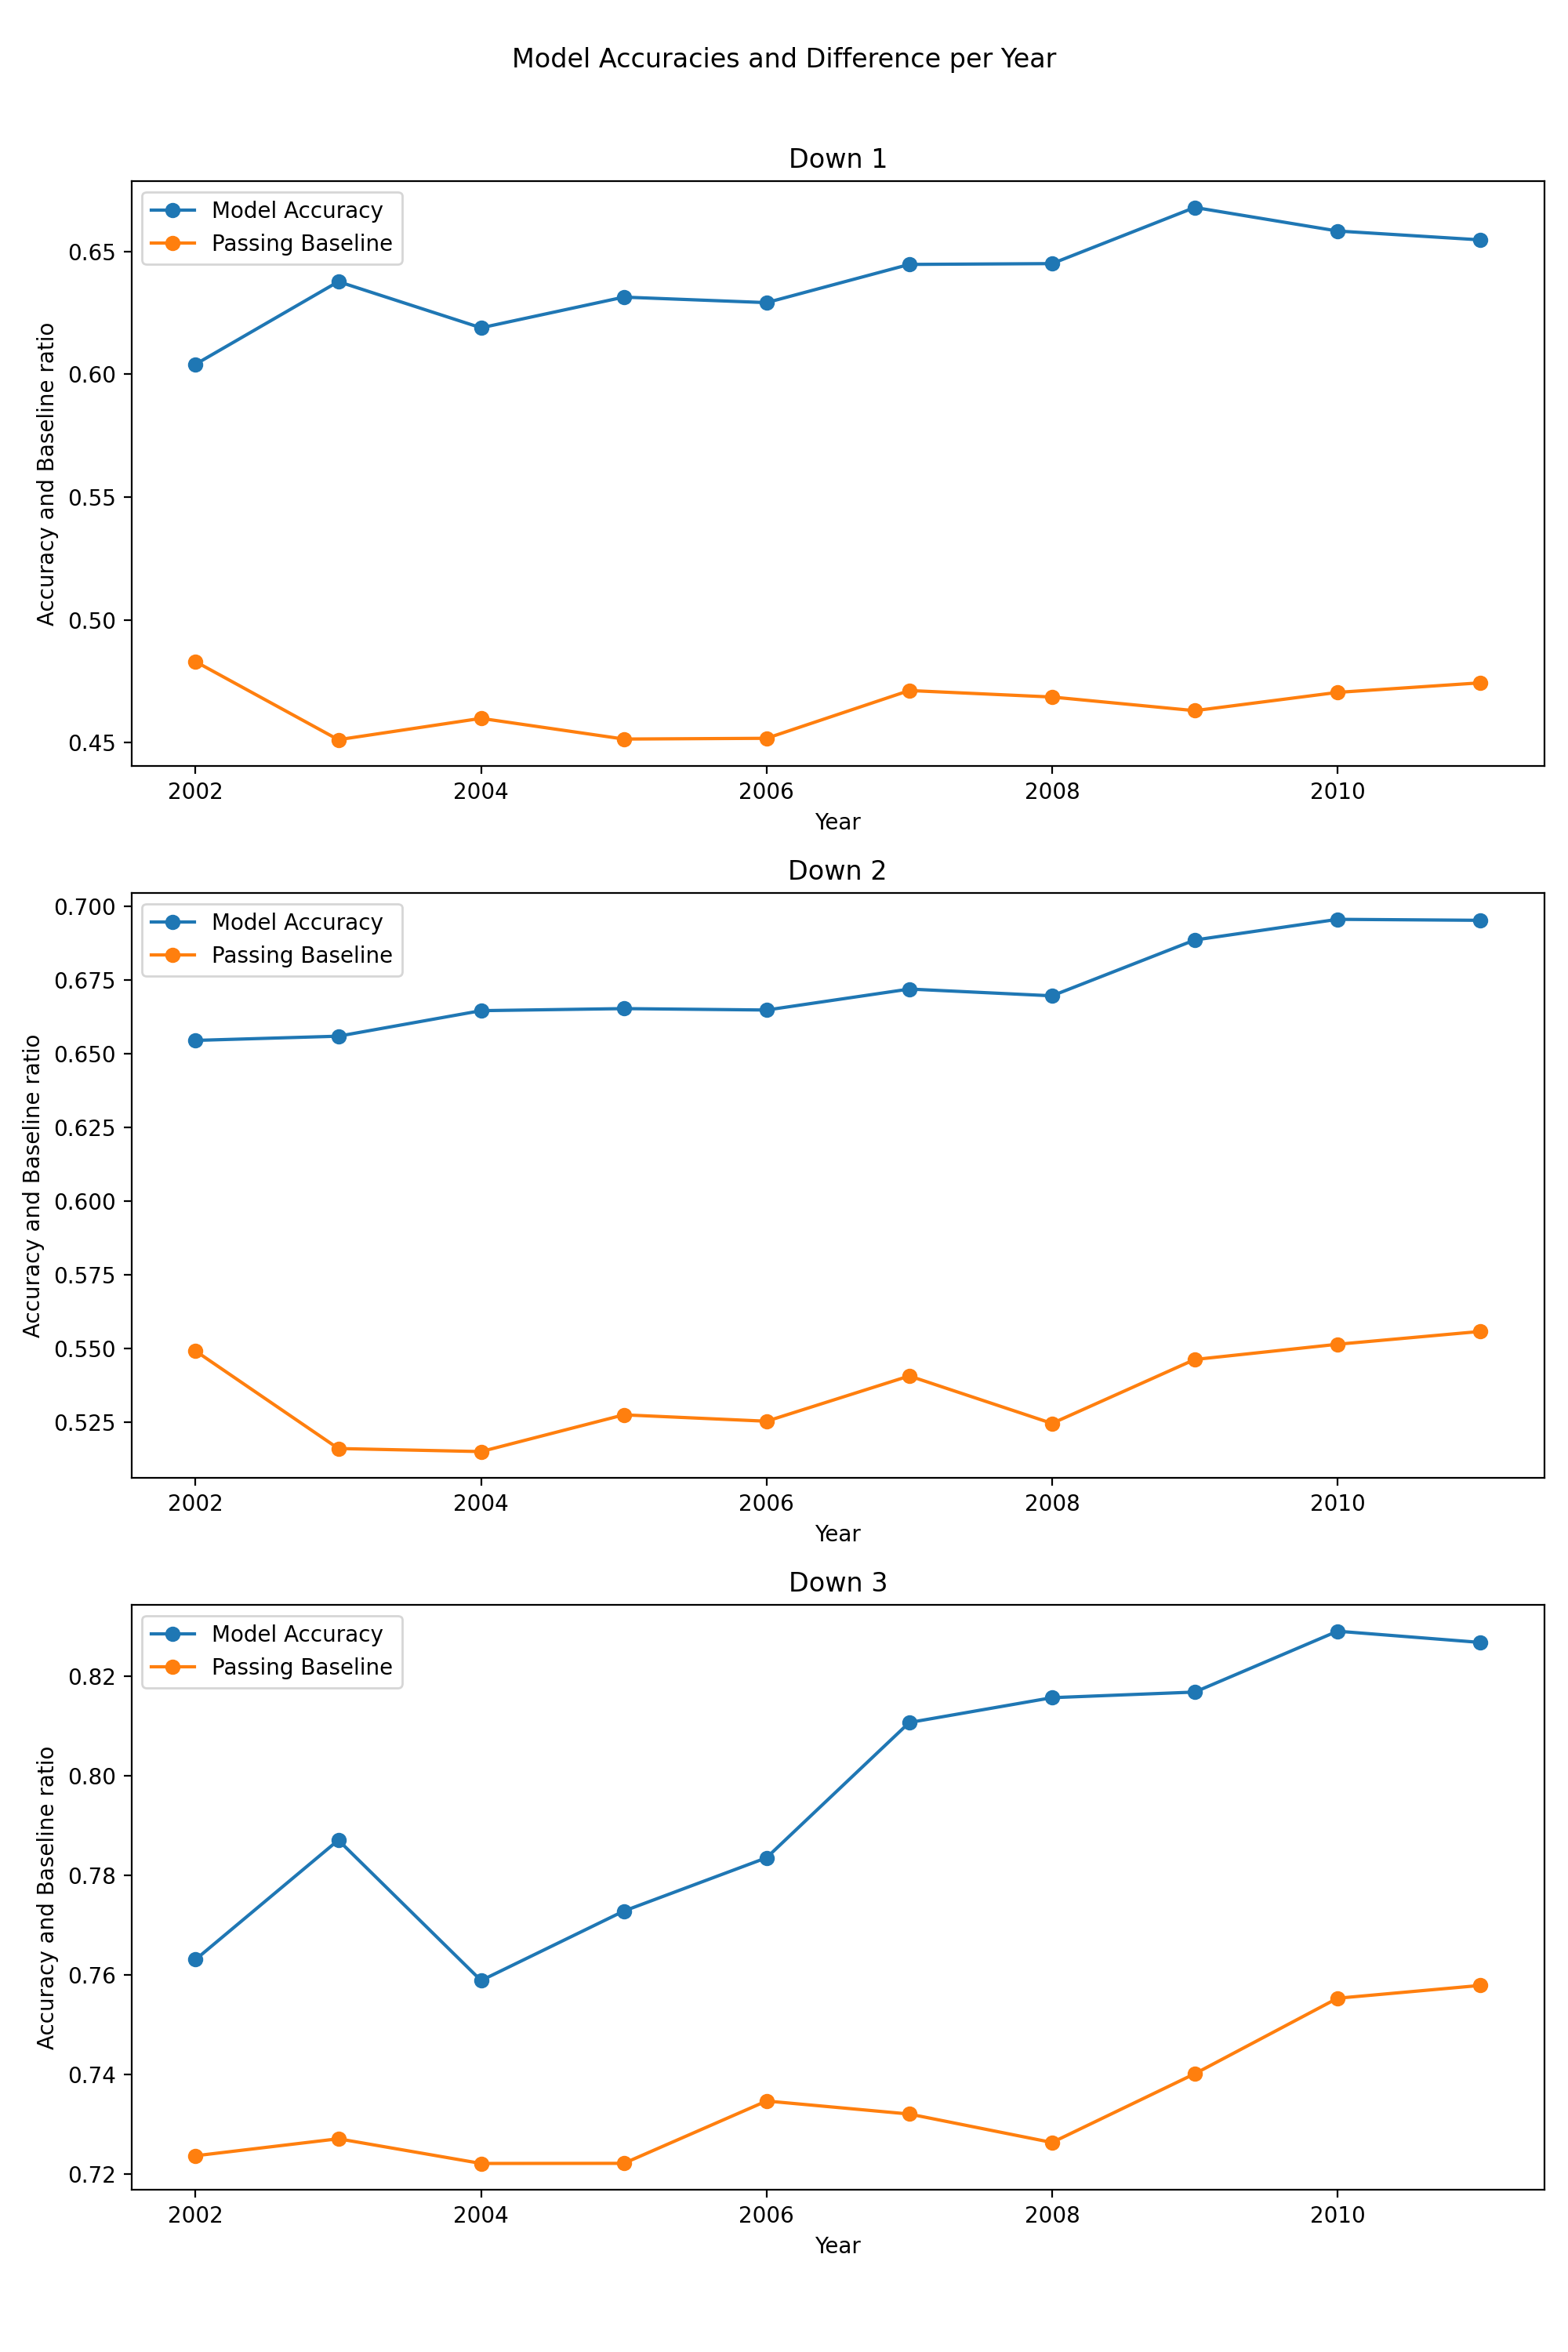

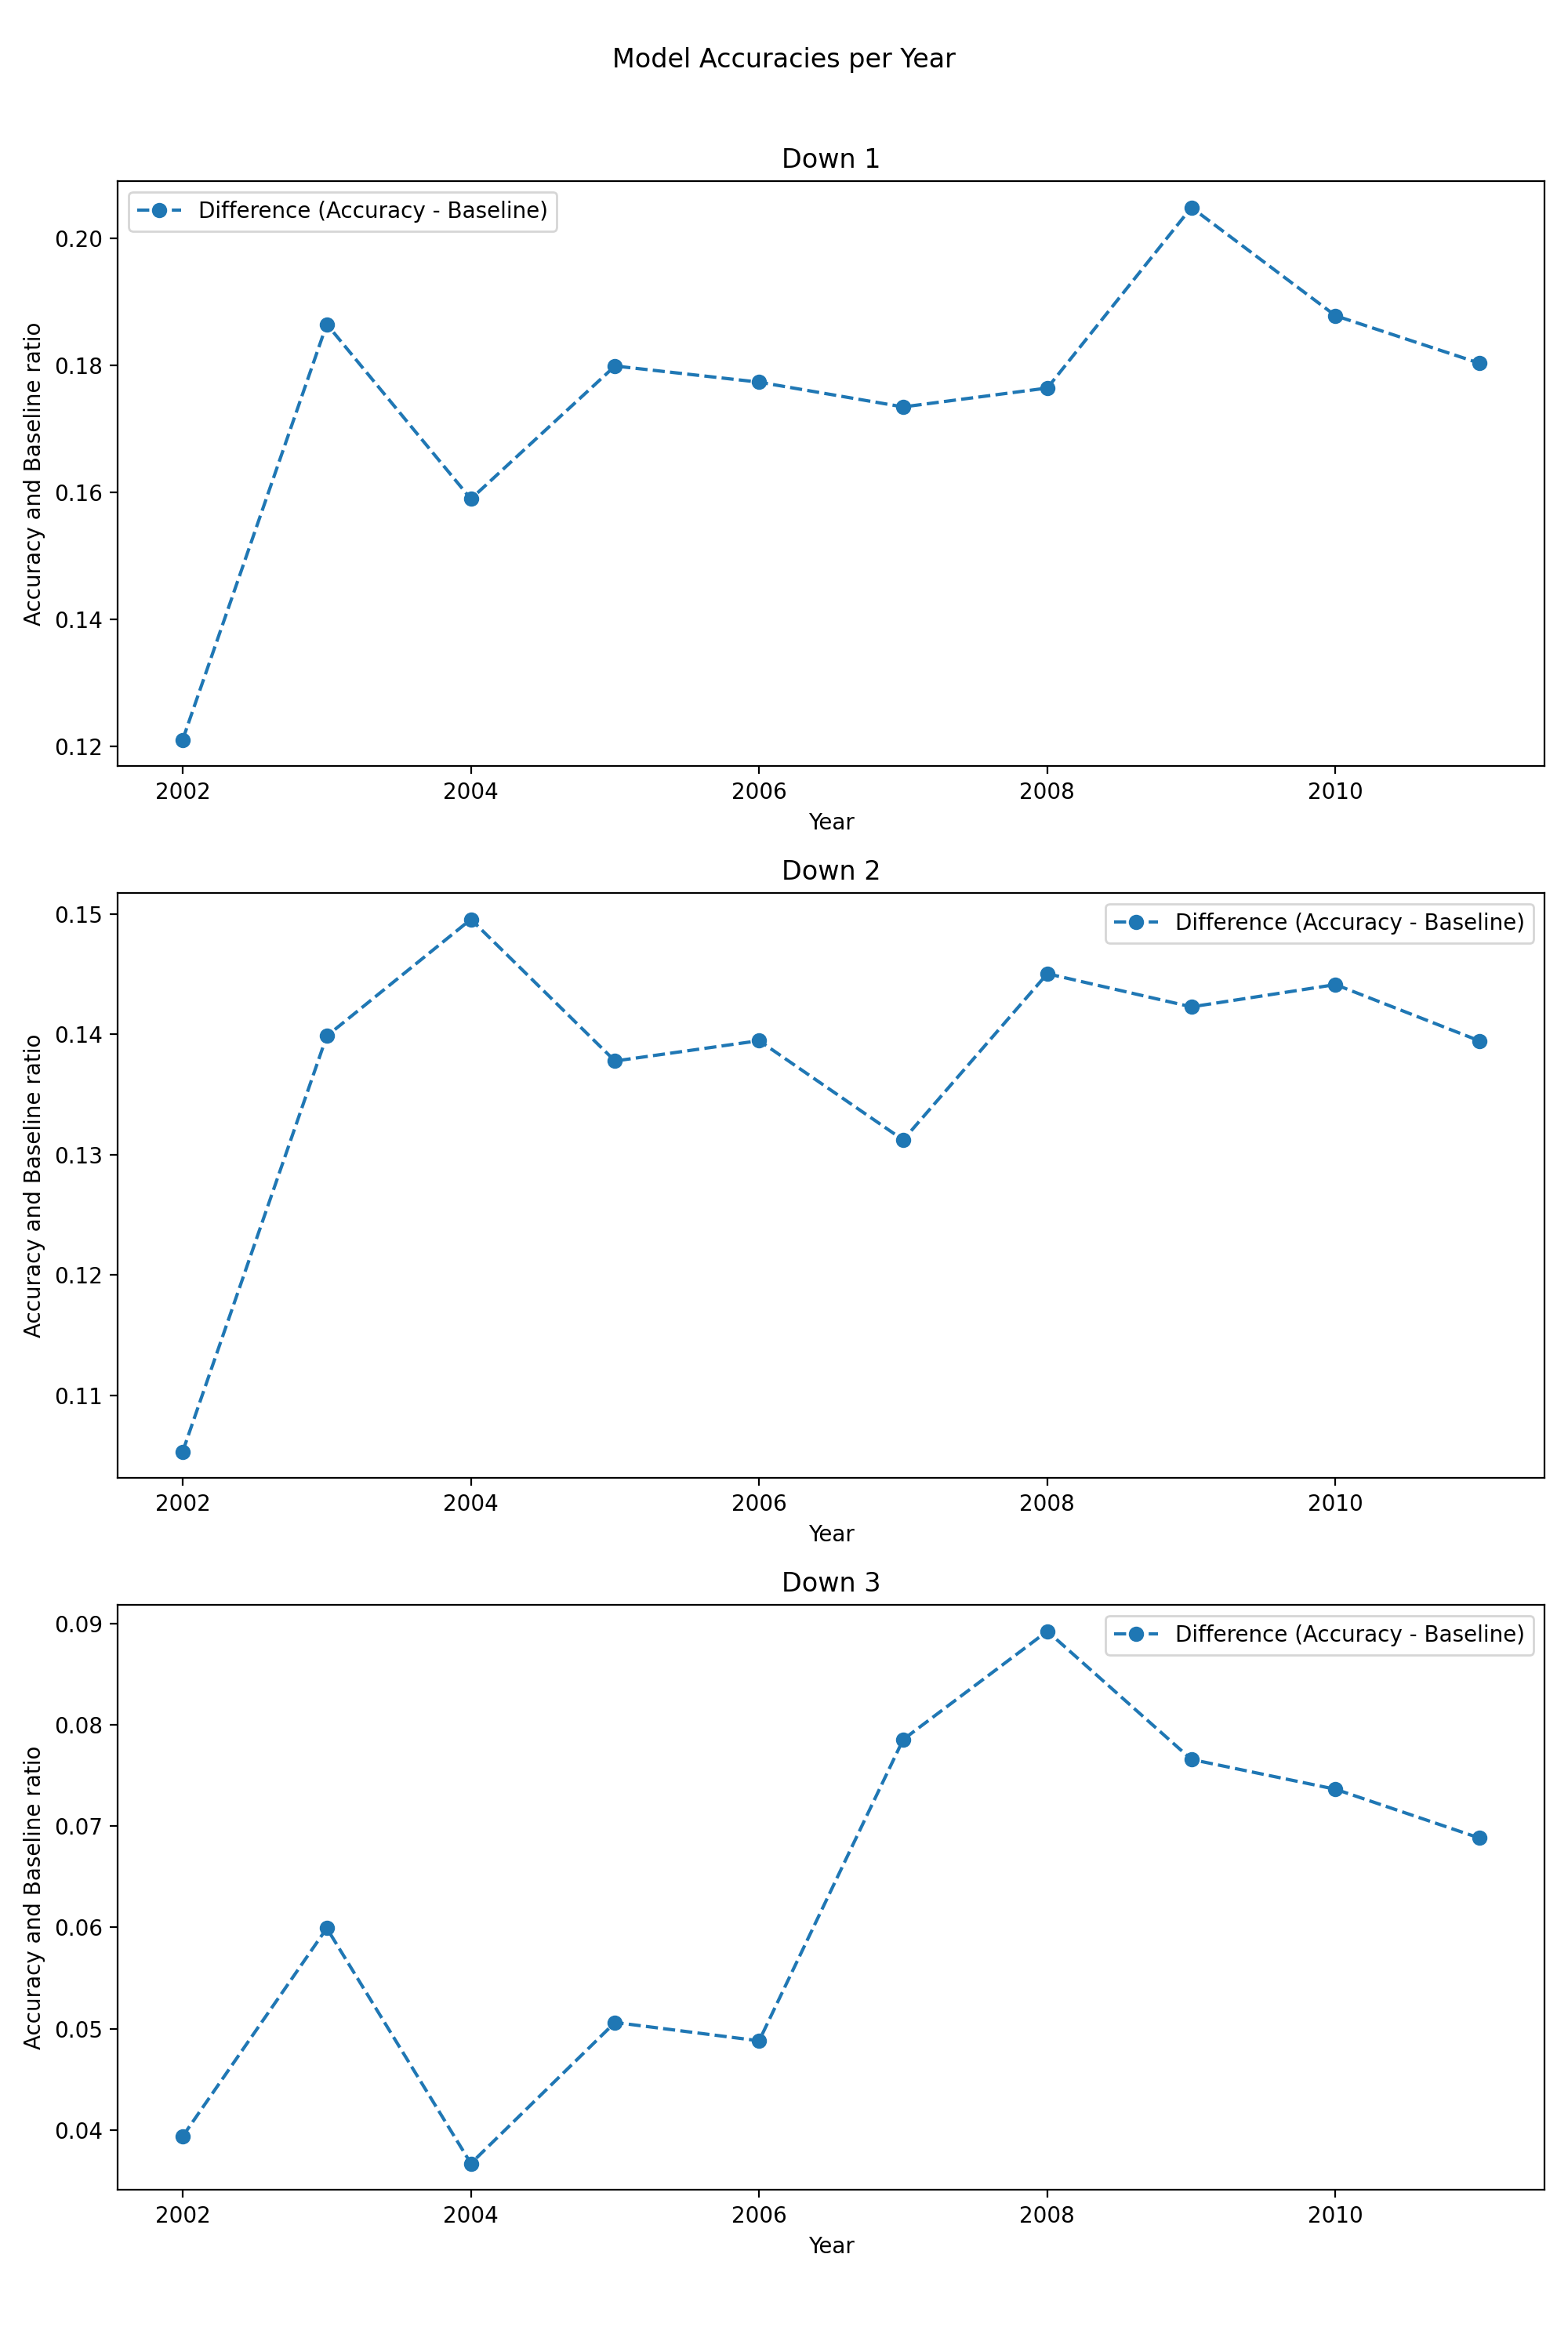

In [ ]:
test_dfdf = test_df
# Calculate the ratio
ratio_df = test_dfdf.groupby(['season','down'])['PassPlay'].value_counts(normalize=True).unstack()
ratio_df.reset_index(inplace=True)

years = range(2002, 2012)  # assuming these are the years covered by the models
downs = [1.0, 2.0, 3.0]  # downs we want to plot

"""
  Plot the accuracies vs baselines per year below
"""

fig, axs = plt.subplots(3, figsize=(10,15))
fig.suptitle('Model Accuracies and Difference per Year')

for idx, down in enumerate(downs):
    accuracies = [best_models[(year, down)]['Accuracy'] for year in years]
    pass_ratio = ratio_df[ratio_df['down']==down][1].tolist()

    axs[idx].plot(years, accuracies, marker='o', label='Model Accuracy')
    axs[idx].plot(years, pass_ratio, marker='o', label='Passing Baseline')

    axs[idx].set_title('Down ' + str(int(down)))
    axs[idx].set_xlabel('Year')
    axs[idx].set_ylabel('Accuracy and Baseline ratio')
    axs[idx].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


"""
  Plot just the accuracies per year below
"""

# create subplots for each quarter
fig, axs = plt.subplots(3, figsize=(10,15))
fig.suptitle('Model Accuracies per Year')

# plotting the graph
for idx, down in enumerate(downs):
    accuracies = [best_models[(year, down)]['Accuracy'] for year in years]
    pass_ratio = ratio_df[ratio_df['down']==down][1].tolist()
    diff = [accuracies[i] - pass_ratio[i] for i in range(len(accuracies))]


    axs[idx].plot(years, diff, marker='o', linestyle='dashed', label='Difference (Accuracy - Baseline)')

    axs[idx].set_title('Down ' + str(int(down)))
    axs[idx].set_xlabel('Year')
    axs[idx].set_ylabel('Accuracy and Baseline ratio')
    axs[idx].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # adjust the layout
plt.show()

In [ ]:
from collections import defaultdict

# Initialize defaultdicts to accumulate total importance and count
total_features_per_down = defaultdict(lambda: defaultdict(float))
counts_per_down = defaultdict(lambda: defaultdict(int))

for year_down_tuple, result in best_models.items():
    down = year_down_tuple[1]
    important_features = result['Important Features']
    for feature, value in important_features.items():
        total_features_per_down[down][feature] += value  # Sum up total importance
        counts_per_down[down][feature] += 1  # Count up number of additions

# Initialize defaultdict for averages
avg_features_per_down = defaultdict(lambda: defaultdict(float))

# Calculate averages
for down, features in total_features_per_down.items():
    for feature, total_value in features.items():
        count = counts_per_down[down][feature]
        avg_features_per_down[down][feature] = total_value / count  # Average importance


for down, features in avg_features_per_down.items():
    print(f"Down {down}:")
    sorted_features = sorted(features.items(), key=lambda x: x[1], reverse=True)[:5]
    for feature, avg_value in sorted_features:
        print(f"  {feature}: {avg_value}")



Down 1.0:
  ydline: 0.14748954724350613
  in_game_pass_ratio: 0.14125168947796882
  sec: 0.13767265142790097
  min: 0.12377696288789711
  previous_play_yard: 0.10958885058033854
Down 2.0:
  ydline: 0.14225847276399334
  in_game_pass_ratio: 0.1417227352961608
  sec: 0.13584360055559208
  min: 0.1339920116541732
  defscore: 0.08845792546878689
Down 3.0:
  in_game_pass_ratio: 0.12845070404274134
  ydline: 0.1268200412118582
  min: 0.12275886957856108
  sec: 0.11558872348902423
  is_shotgun: 0.08365660443980885


In [ ]:
avg_features_per_year = defaultdict(lambda: defaultdict(float))

for year_down_tuple, result in best_models.items():
    year = year_down_tuple[0]
    important_features = result['Important Features']
    for feature, value in important_features.items():
        avg_features_per_year[year][feature] += value / len(results)

for year, features in avg_features_per_year.items():
    print(f"Year {year}:")
    sorted_features = sorted(features.items(), key=lambda x: x[1], reverse=True)[:5]
    for feature, avg_value in sorted_features:
        print(f"  {feature}: {avg_value}")

Year 2002:
  ydline: 0.14532586251873428
  in_game_pass_ratio: 0.14288950629216485
  sec: 0.13335439808065802
  min: 0.13282659316651269
  defscore: 0.09179498207017515
Year 2003:
  ydline: 0.14631425932813136
  in_game_pass_ratio: 0.14015342346860304
  sec: 0.1345281300719714
  min: 0.12933124714723443
  previous_play_yard: 0.09121809510061138
Year 2004:
  ydline: 0.14535237595450456
  in_game_pass_ratio: 0.14401632908829268
  sec: 0.13488948467105308
  min: 0.13228981047040717
  previous_play_yard: 0.09188139999824844
Year 2005:
  ydline: 0.14515383782247265
  in_game_pass_ratio: 0.1427212567526994
  sec: 0.13674336697989128
  min: 0.13021232865530707
  previous_play_yard: 0.09285996013461503
Year 2006:
  ydline: 0.1419171049146328
  in_game_pass_ratio: 0.14003267979726705
  sec: 0.1322472478048856
  min: 0.12841444063337354
  previous_play_yard: 0.09111720896908142
Year 2007:
  ydline: 0.13798815830936423
  in_game_pass_ratio: 0.13326414626420263
  sec: 0.12647656302323532
  min: 0.

## Other features we could have engineered

- whether a team had just converted a 1st down.
- player stats, metrics (season, in-game)
- team stats, metrics (season, in-game)
